# Generating Names with a Character-Level RNN
https://pytorch.org/tutorials/intermediate/char_rnn_generation_tutorial.html

## Prepare the Data

`wget https://download.pytorch.org/tutorial/data.zip`

`unzip data.zip`

`mv data/ names/`

In [1]:
from io import open
import glob

def findFiles(path): return glob.glob(path)

print(findFiles('../data/names/names/*.txt'))

import unicodedata
import string

all_letters = string.ascii_letters + ' .,;\''
n_letters = len(all_letters)

# turn a unicode string to plain ascii, thanks to http://stackoverflow.com/a/518232/2809427
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
        and c in all_letters
    )

print(unicodeToAscii('Ślusàrski'))

['../data/names/names/Russian.txt', '../data/names/names/Chinese.txt', '../data/names/names/Greek.txt', '../data/names/names/Vietnamese.txt', '../data/names/names/Spanish.txt', '../data/names/names/Scottish.txt', '../data/names/names/Dutch.txt', '../data/names/names/French.txt', '../data/names/names/Japanese.txt', '../data/names/names/Czech.txt', '../data/names/names/Portuguese.txt', '../data/names/names/Arabic.txt', '../data/names/names/English.txt', '../data/names/names/Korean.txt', '../data/names/names/Italian.txt', '../data/names/names/Polish.txt', '../data/names/names/German.txt', '../data/names/names/Irish.txt']
Slusarski


In [2]:
# build the category_lines dictionary, a list of names per language
category_lines = {}
all_categories = []

# read a file and split into lines
def readLines(filename):
    lines = open(filename, encoding='utf-8').read().strip().split('\n')
    return [unicodeToAscii(line) for line in lines]

for filename in findFiles('../data/names/names/*.txt'):
    category = filename.split('/')[-1].split('.')[0]
    all_categories.append(category)
    lines = readLines(filename)
    category_lines[category] = lines
    
n_categories = len(all_categories)

print('n_categories:', n_categories)
print('names per category:', [{c: len(category_lines[c])} for c in all_categories])

n_categories: 18
names per category: [{'Russian': 9408}, {'Chinese': 268}, {'Greek': 203}, {'Vietnamese': 73}, {'Spanish': 298}, {'Scottish': 100}, {'Dutch': 297}, {'French': 277}, {'Japanese': 991}, {'Czech': 519}, {'Portuguese': 74}, {'Arabic': 2000}, {'English': 3668}, {'Korean': 94}, {'Italian': 709}, {'Polish': 139}, {'German': 724}, {'Irish': 232}]


In [3]:
category_lines['Italian'][:5]

['Abandonato', 'Abatangelo', 'Abatantuono', 'Abate', 'Abategiovanni']

## Turning Names and Categories into Tensors

Using one-hot encoding, where the input line makes a 2D matrix: `<line_length x 1 x n_letters>`
- "That extra 1 dimension is because PyTorch assumes everything is in batches - we’re just using a batch size of 1 here."

In [4]:
import torch

# one-hot vector for category
def categoryTensor(category):
    li = all_categories.index(category)
    tensor = torch.zeros(1, n_categories)
    tensor[0][li] = 1
    return tensor

# one-hot matrix of first to last lettters (not including EOS) for input
def inputTensor(line):
    tensor = torch.zeros(len(line), 1, n_letters) # 1 == batch size
    for li in range(len(line)):
        letter = line[li]
        tensor[li][0][all_letters.find(letter)] = 1
    return tensor

# LongTensor of second letter to end (EOS) for target
def targetTensor(line):
    letter_indexes = [all_letters.find(line[li]) for li in range(1, len(line))]
    letter_indexes.append(n_letters - 1) # EOS
    return torch.LongTensor(letter_indexes)

print('---en_tensor---')
en_tensor = categoryTensor('English')
print(en_tensor.size(), en_tensor)

print('---j_tensor---')
j_tensor = inputTensor('J')
print(j_tensor.size(), j_tensor)

print('---jones_tensor---')
jones_tensor = inputTensor('Jones')
print(jones_tensor.size())

print('---target_tensor---')
target_tensor = targetTensor('Jones')
print(target_tensor.size(), target_tensor)

---en_tensor---
torch.Size([1, 18]) tensor([[ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
          1.,  0.,  0.,  0.,  0.,  0.]])
---j_tensor---
torch.Size([1, 1, 57]) tensor([[[ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
           0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
           0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
           0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
           0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
           0.,  0.]]])
---jones_tensor---
torch.Size([5, 1, 57])
---target_tensor---
torch.Size([5]) tensor([ 14,  13,   4,  18,  56])


## Creating the Network

![](https://i.imgur.com/Z2xbySO.png)

Note that `category` is also being concatenated to the `combined` layer.

In [5]:
import torch.nn as nn

class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()
        self.hidden_size = hidden_size
        
        self.i2h = nn.Linear(n_categories + input_size + hidden_size, hidden_size)
        self.i2o = nn.Linear(n_categories + input_size + hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)
        
    # NOTE: this example only works as-is in PyTorch 0.4+
    # https://stackoverflow.com/questions/50475094/runtimeerror-addmm-argument-mat1-position-1-must-be-variable-not-torch
    def forward(self, category, input, hidden):
        combined = torch.cat((category, input, hidden), 1)
        hidden = self.i2h(combined)
        output = self.i2o(combined)
        output = self.softmax(output)
        return output, hidden
    
    def initHidden(self):
        return torch.zeros(1, self.hidden_size) # TODO: why isn't this random?

## Training

In [6]:
import random

# random item from a list
def randomChoice(l):
    return l[random.randint(0, len(l) - 1)]

# get a random category and random line from that category
def randomTrainingPair():
    category = randomChoice(all_categories)
    line = randomChoice(category_lines[category])
    return category, line

# make category, input, and target tensors from a random category, line pair
def randomTrainingExample():
    category, line = randomTrainingPair()
    category_tensor = categoryTensor(category)
    input_line_tensor = inputTensor(line)
    target_line_tensor = targetTensor(line)
    return category_tensor, input_line_tensor, target_line_tensor

In [7]:
for i in range(10):
    category, line = randomTrainingPair()
    print('category =', category, '/ line =', line)

category = German / line = Geissler
category = Arabic / line = Guirguis
category = Spanish / line = Mingo
category = Irish / line = O'Doherty
category = Irish / line = Ahearn
category = Greek / line = Gomatos
category = Arabic / line = Kouri
category = Italian / line = Pagani
category = Spanish / line = Ojeda
category = Czech / line = Ludwig


### Training the Network

For the loss function `nn.NLLLoss` is appropriate, since the last layer of the RNN is `nn.LogSoftmax`.

Each loop of training will:
- Create input and target tensors
- Create a zeroed initial hidden state
- Read each letter in and
    - Keep hidden state for next letter
- Compare final output to target
- Back-propagate
- Return the output and loss

In [25]:
criterion = nn.NLLLoss()
lr = 0.0005 # if you set this too high, it might explode; if too low, it might not learn

def train(rnn, category_tensor, input_line_tensor, target_line_tensor):
    target_line_tensor.unsqueeze_(-1) # TODO: ???
    hidden = rnn.initHidden()
    
    rnn.zero_grad()
    
    loss = 0
    
    for i in range(input_line_tensor.size(0)):
        output, hidden = rnn(category_tensor, input_line_tensor[i], hidden)
        l = criterion(output, target_line_tensor[i])
        loss += l
        
    loss.backward()
    
    # add parameters' gradients to their values, multiplied by learning rate
    for p in rnn.parameters():
        p.data.add_(-lr, p.grad.data)
        
    return output, loss.item() / input_line_tensor.size(0)

In [15]:
import time
import math

def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return f'{m}m {s:.0f}s'

In [16]:
n_hidden = 128
rnn = RNN(n_letters, n_hidden, n_letters)

n_iters = 100000
print_every = 5000
plot_every = 500

# keep track of losses for plotting
total_loss = 0 # reset every plot_every iters
all_losses = []

start = time.time()

for iter in range(1, n_iters + 1):
    output, loss = train(rnn, *randomTrainingExample())
    total_loss += loss
    
    if iter % print_every == 0:
        print(f'{timeSince(start)} ({iter} {iter / n_iters * 100}%) {loss:.4f}')
        
    if iter % plot_every == 0:
        all_losses.append(total_loss / plot_every)
        total_loss = 0

0m 10s (5000 5.0%) 2.8819
0m 21s (10000 10.0%) 2.8509
0m 31s (15000 15.0%) 3.0548
0m 42s (20000 20.0%) 2.5713
0m 52s (25000 25.0%) 3.1039
1m 1s (30000 30.0%) 2.9984
1m 12s (35000 35.0%) 2.4803
1m 22s (40000 40.0%) 2.6328
1m 32s (45000 45.0%) 2.0839
1m 43s (50000 50.0%) 2.0518
1m 53s (55000 55.00000000000001%) 2.4290
2m 4s (60000 60.0%) 2.5342
2m 14s (65000 65.0%) 2.1462
2m 25s (70000 70.0%) 2.5053
2m 35s (75000 75.0%) 1.8807
2m 45s (80000 80.0%) 1.8083
2m 56s (85000 85.0%) 2.7331
3m 6s (90000 90.0%) 2.2380
3m 17s (95000 95.0%) 1.9145
3m 27s (100000 100.0%) 2.3711


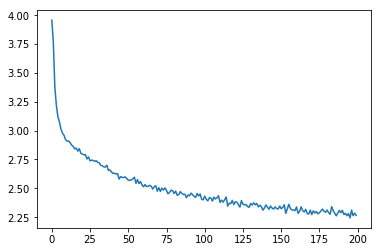

In [18]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

%matplotlib inline
plt.figure()
plt.plot(all_losses)

## Sampling the Network

To sample we give the network a letter and ask what the next one is, feed that in as the next letter, and repeat until the EOS token.
1. Create tensors for input category, starting letter, and empty hidden state
2. Create a string output_name with the starting letter
3. Up to a maximum output length,
    - Feed the current letter to the network
    - Get the next letter from highest output, and next hidden state
    - If the letter is EOS, stop here
    - If a regular letter, add to output_name and continue
4. Return the final name

In [22]:
max_length = 20

# sample from a category and starting letter
def sample(category, start_letter='A'):
    with torch.no_grad(): # no need to track history in sampling
        category_tensor = categoryTensor(category)
        input = inputTensor(start_letter)
        hidden = rnn.initHidden()
        
        output_name = start_letter
        
        for i in range(max_length):
            output, hidden = rnn(category_tensor, input[0], hidden)
            topv, topi = output.topk(1) # topk(1) gets the index of the greatest value
            topi = topi[0][0]
            if topi == n_letters - 1:
                break
            else:
                letter = all_letters[topi]
                output_name += letter
            input = inputTensor(letter)
            
        return output_name
    
# get multiple samples from one category and multiple starting letters
def samples(category, start_letters='ABC'):
    for start_letter in start_letters:
        print(sample(category, start_letter))
        
print('RUSSIAN:')
samples('Russian', 'RUS')
print()

print('GERMAN:')
samples('German', 'GER')
print()

print('SPANISH:')
samples('Spanish', 'SPA')
print()

print('CHINESE:')
samples('Chinese', 'CHI')

RUSSIAN:
Rouhan
Uanien
Sanovov

GERMAN:
Garer
Earer
Rouer

SPANISH:
Sana
Para
Aara

CHINESE:
Can
Han
Ian


**TODO**: use start of sentence token so that sampling can be doen without choosing a start letter

![](https://i.imgur.com/jzVrf7f.png)

Sean Robertson: "I added a second linear layer **o2o (after combining hidden and output) to give it more muscle to work with**. There’s also a **dropout** layer, which randomly zeros parts of its input with a given probability (here 0.1) and is usually **used to fuzz inputs to prevent overfitting**. Here we’re using it towards the end of the network to purposely add some chaos and increase sampling variety."

In [23]:
import torch.nn as nn

class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()
        self.hidden_size = hidden_size
        
        self.i2h = nn.Linear(n_categories + input_size + hidden_size, hidden_size)
        self.i2o = nn.Linear(n_categories + input_size + hidden_size, output_size)
        self.o2o = nn.Linear(hidden_size + output_size, output_size)
        self.dropout = nn.Dropout(0.1)
        self.softmax = nn.LogSoftmax(dim=1)
        
    # NOTE: this example only works as-is in PyTorch 0.4+
    # https://stackoverflow.com/questions/50475094/runtimeerror-addmm-argument-mat1-position-1-must-be-variable-not-torch
    def forward(self, category, input, hidden):
        combined_i = torch.cat((category, input, hidden), 1)
        hidden = self.i2h(combined_i)
        output = self.i2o(combined_i)
        combined_o = torch.cat((hidden, output), 1)
        output = self.o2o(combined_o)
        output = self.dropout(output)
        output = self.softmax(output)
        return output, hidden
    
    def initHidden(self):
        return torch.zeros(1, self.hidden_size) # TODO: why isn't this random?

In [26]:
n_hidden = 128
rnn = RNN(n_letters, n_hidden, n_letters)

n_iters = 100000
print_every = 5000
plot_every = 500

# keep track of losses for plotting
total_loss = 0 # reset every plot_every iters
all_losses = []

start = time.time()

for iter in range(1, n_iters + 1):
    output, loss = train(rnn, *randomTrainingExample())
    total_loss += loss
    
    if iter % print_every == 0:
        print(f'{timeSince(start)} ({iter} {iter / n_iters * 100}%) {loss:.4f}')
        
    if iter % plot_every == 0:
        all_losses.append(total_loss / plot_every)
        total_loss = 0

0m 17s (5000 5.0%) 3.1483
0m 34s (10000 10.0%) 3.0390
0m 51s (15000 15.0%) 2.0914
1m 8s (20000 20.0%) 2.6684
1m 25s (25000 25.0%) 2.5847
1m 42s (30000 30.0%) 2.3796
1m 59s (35000 35.0%) 2.1955
2m 16s (40000 40.0%) 2.5113
2m 33s (45000 45.0%) 2.2793
2m 50s (50000 50.0%) 3.0533
3m 6s (55000 55.00000000000001%) 2.5626
3m 23s (60000 60.0%) 2.1104
3m 40s (65000 65.0%) 1.3357
3m 57s (70000 70.0%) 2.0337
4m 14s (75000 75.0%) 2.5217
4m 31s (80000 80.0%) 2.2902
4m 48s (85000 85.0%) 2.4396
5m 4s (90000 90.0%) 1.2252
5m 21s (95000 95.0%) 2.0182
5m 38s (100000 100.0%) 2.8224


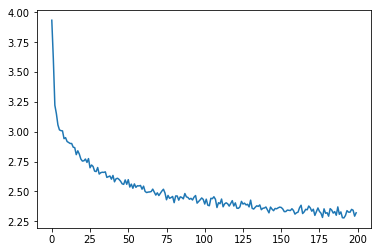

In [27]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

%matplotlib inline
plt.figure()
plt.plot(all_losses)